# 0. Setup

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from transformers import ViTFeatureExtractor, ViTForImageClassification
import time
from fvcore.nn import FlopCountAnalysis, parameter_count_table

In [2]:
!pip install fvcore

In [4]:
print("Cuda is available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

Cuda is available:  True
cuda


# 1. Data Fetch

### a. CIFAR-10 Dataset

In [5]:
# Define the transforms

cifar10_transform_augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

cifar10_transform_normal = transforms.Compose([    
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [6]:
# Load training datasets

train_set_temp = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar10_transform_normal)
augment_train_set_temp = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar10_transform_augment)
val_set_temp = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=cifar10_transform_normal)

# function to stratify and split the dataset

def stratified_split(dataset, val_size=0.2, random_seed=23):
    np.random.seed(random_seed)
    indices = np.arange(len(dataset))
    targets = np.array(dataset.targets)

    train_indices = []
    val_indices = []

    for class_index in np.unique(targets):
        class_indices = indices[targets == class_index]
        np.random.shuffle(class_indices)
        split = int(np.floor(val_size * len(class_indices)))
        val_indices.extend(class_indices[:split])
        train_indices.extend(class_indices[split:])

    return train_indices, val_indices

# function to plot class distribution
def plot_class_distribution(data, title):
    counter = Counter(data)
    classes = list(counter.keys())
    counts = list(counter.values())
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

# Split train set into training and validation set

# train_set, val_set = random_split(train_set_temp, [40000, 10000])
train_indices, val_indices = stratified_split(train_set_temp, val_size=0.2)

train_set = Subset(dataset=train_set_temp, indices=train_indices)
augment_train_set = Subset(dataset=augment_train_set_temp, indices=train_indices)
val_set = Subset(dataset=val_set_temp, indices=val_indices)

# Create train and validation dataloaders

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
train_augment_loader = DataLoader(augment_train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)

# Load test datasets

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=cifar10_transform_normal)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cifar10_dataloaders = {
    'train_loader': train_loader,
    'augment_train_loader': train_augment_loader,
    'val_loader': val_loader,
    'test_loader': test_loader
}

cifar10_dataloaders_augmented = {
    'train_loader': train_augment_loader,
    'val_loader': val_loader,
    'test_loader': test_loader
}


100%|██████████| 170498071/170498071 [00:03<00:00, 48912693.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
for images, labels in val_loader:
    print(type(images))
    break

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5654321].

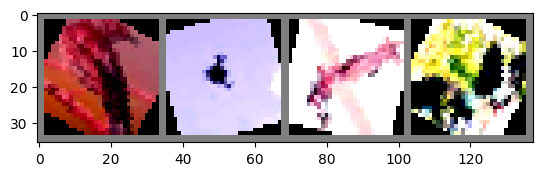

In [35]:
# function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
train_iter = iter(train_augment_loader)
images, labels = next(train_iter)

# display images
imshow(torchvision.utils.make_grid(images))

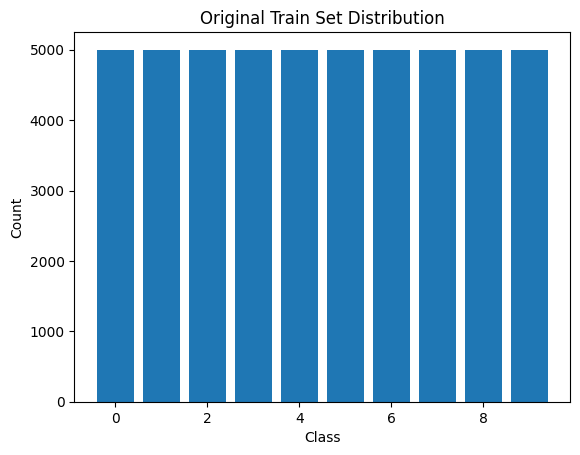

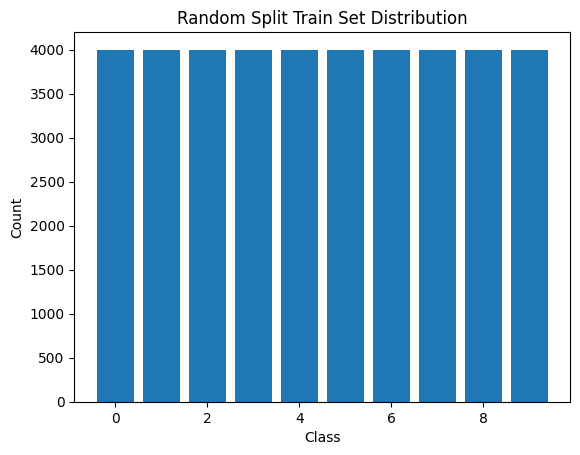

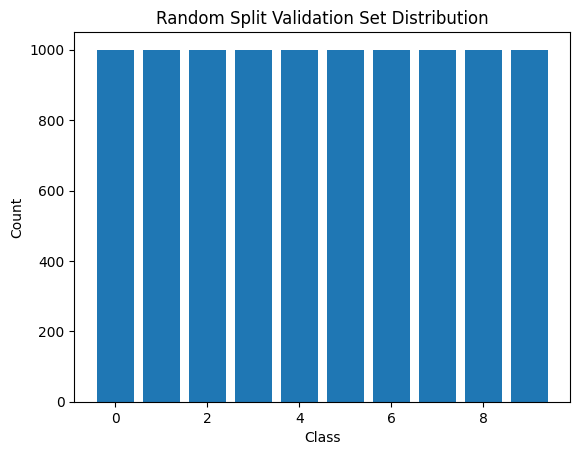

In [36]:
plot_class_distribution(train_set_temp.targets, "Original Train Set Distribution")
plot_class_distribution([train_set_temp.targets[idx] for idx in train_set.indices], "Random Split Train Set Distribution")
plot_class_distribution([train_set_temp.targets[idx] for idx in val_set.indices], "Random Split Validation Set Distribution")

# 2. Trainer Class

A Trainer class to consolidate all learning. Parameters: model, optimizer, loss_fn, and epoch

In [7]:
class Trainer():
    def __init__(self, model, optimizer, loss_fn, dataloaders, per_batch=False):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.per_batch = per_batch # if per batch results wants to be outputted instead of per epoch
        self.epoch = 1
        self.training_losses = []
        self.val_losses = []
        self.training_accuracies = []
        self.val_accuracies = []
        self.time = 0
        self.dataloaders = dataloaders
        self.flop_count = 0
        self.parameter_count = 0

    def flop_analysis(self):
        # FLOP analysis
        input_size = self.dataloaders.get('train_loader').dataset[0][0].shape
        dummy_input = torch.randn(1,*input_size).to(device)
        self.flop_count = FlopCountAnalysis(self.model, dummy_input).total() # total number of FLOPS - Floating Point Operations (signifies computational cost)
        self.parameter_count = parameter_count_table(self.model) # total number of parameters (signifies model complexity)

    def train(self, epoch=1, rerun=False):
        self.epoch = epoch
        if rerun:
            self.training_losses = []
            self.val_losses = []
            self.training_accuracies = []
            self.val_accuracies = []
            self.time = 0

        # start timing
        if device.type == "cpu":
            start_time = time.time()
        elif device.type == "cuda":
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()

        for epoch_i in range(self.epoch): # training epoch
            train_running_loss = 0.0
            train_total_correct = 0
            train_total_samples = 0

            # training phase
            self.model.train() # set to training mode
            for i, data in enumerate(self.dataloaders.get('train_loader')): # mini-batch gradient descent
                # get the inputs of each batch
                inputs, labels = data
                # transfer to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients for this batch
                self.optimizer.zero_grad()
                # forward pass
                outputs = self.model(inputs)
                # calculate loss
                loss = self.loss_fn(outputs, labels)
                # backward pass (compute gradients)
                loss.backward()
                # optimize (update parameters)
                self.optimizer.step()

                _, predicted = torch.max(outputs, 1)

                train_total_correct += (predicted == labels).sum().item()
                train_total_samples += labels.size(0)
                train_running_loss += loss.item()

                if self.per_batch:
                    # calculate accuracy
                    accuracy = 100*train_total_correct/train_total_samples
                    # Print statistics
                    print(f'Epoch {self.epoch + 1}, Batch {i+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.2f}%')

            # validation phase
            self.model.eval() # set to validation mode
            val_running_loss = 0.0
            val_total_correct = 0
            val_total_samples = 0

            with torch.no_grad():
                for inputs, labels in self.dataloaders.get('val_loader'):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = self.model(inputs)
                    loss = self.loss_fn(outputs, labels)
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)

                    val_total_samples += labels.size(0)
                    val_total_correct += (predicted == labels).sum().item()

            if not self.per_batch:
                # calculate training accuracy
                train_accuracy = 100*train_total_correct/train_total_samples
                train_loss = train_running_loss/len(self.dataloaders.get('train_loader'))
                # calculate validation accuracy
                val_accuracy = 100*val_total_correct/val_total_samples
                val_loss = val_running_loss / len(self.dataloaders.get('val_loader'))

                self.training_accuracies.append(train_accuracy)
                self.training_losses.append(train_loss)
                self.val_accuracies.append(val_accuracy)
                self.val_losses.append(val_loss)

                print(f'Epoch {epoch_i + 1}/{self.epoch}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%.')

        # end timing and calculate time
        if device.type == "cpu":
            end_time = time.time()
            self.time = end_time - start_time
        elif device.type == "cuda":
            end_event.record()
            torch.cuda.synchronize()
            self.time = start_event.elapsed_time(end_event)/1000

        print(f'Finished Training after {self.time:.4f} seconds')

    def test(self):
        self.model.eval() # set to validation mode
        test_running_loss = 0.0
        test_total_correct = 0
        test_total_samples = 0

        with torch.no_grad():

            for inputs, labels in self.dataloaders.get('test_loader'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_total_samples += labels.size(0)
                test_total_correct += (predicted == labels).sum().item()

        # calculate validation accuracy
        test_accuracy = 100*test_total_correct/test_total_samples
        test_loss = test_running_loss / len(self.dataloaders.get('test_loader'))
        return test_accuracy, test_loss

    def plot(self, type='accuracy'):
        # Create figure and axes
        fig, ax = plt.subplots()
        # Plot lines
        if type == 'accuracy':
            ax.plot(range(1,len(self.training_accuracies)+1), self.training_accuracies, label='Training Accuracy', color='blue', linewidth=2)
            ax.plot(range(1,len(self.val_accuracies)+1), self.val_accuracies, label='Validation Accuracy', color='lightblue', linewidth=1)
            ax.set_ylabel('accuracy (%)')
        elif type == 'loss':
            ax.plot(range(1,len(self.training_losses)+1), self.training_losses, label='Training Loss', color='red', linewidth=2)
            ax.plot(range(1,len(self.val_losses)+1), self.val_losses, label='Validation Loss', color='lightcoral', linewidth=1)
            ax.set_ylabel('loss')
        else:
            print("Invalid type. Please choose 'accuracy' or 'loss'.")
            return

        # Add some text for labels, title, and custom x-axis tick labels, etc.
        ax.set_xlabel('iteration')
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.legend()

        # show the plot
        plt.show()

# 3. LeNet-5 (from scratch)

### a. Original Architecture

In [8]:
# Define the LeNet-5 architecture

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 16*5*5) # flatten
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

In [25]:
# create an instance of LeNet5 model
lenet5 = LeNet5()
lenet5 = lenet5.to(device)

# define the loss function and optimizer
criterion_lenet5 = nn.CrossEntropyLoss()
optimizer_lenet5 = optim.SGD(lenet5.parameters(), lr=0.001, momentum=0.9)

# create an instance for lenet 5 trainer
lenet5_trainer = Trainer(model=lenet5, optimizer=optimizer_lenet5, loss_fn=criterion_lenet5, dataloaders=cifar10_dataloaders)

In [27]:
lenet5_trainer.train(epoch=40)

Epoch 1/40, Loss: 1.2637, Accuracy: 54.61%, Validation Loss: 1.3162, Validation Accuracy: 53.02%.
Epoch 2/40, Loss: 1.2602, Accuracy: 54.76%, Validation Loss: 1.2937, Validation Accuracy: 53.19%.
Epoch 3/40, Loss: 1.2545, Accuracy: 55.07%, Validation Loss: 1.2909, Validation Accuracy: 53.31%.
Epoch 4/40, Loss: 1.2530, Accuracy: 55.06%, Validation Loss: 1.2898, Validation Accuracy: 53.47%.
Epoch 5/40, Loss: 1.2508, Accuracy: 55.35%, Validation Loss: 1.2963, Validation Accuracy: 53.25%.
Epoch 6/40, Loss: 1.2449, Accuracy: 55.36%, Validation Loss: 1.2879, Validation Accuracy: 53.71%.
Epoch 7/40, Loss: 1.2400, Accuracy: 55.58%, Validation Loss: 1.2816, Validation Accuracy: 53.92%.
Epoch 8/40, Loss: 1.2355, Accuracy: 55.69%, Validation Loss: 1.2792, Validation Accuracy: 53.75%.
Epoch 9/40, Loss: 1.2347, Accuracy: 55.87%, Validation Loss: 1.2820, Validation Accuracy: 53.95%.
Epoch 10/40, Loss: 1.2305, Accuracy: 55.79%, Validation Loss: 1.2730, Validation Accuracy: 53.94%.
Epoch 11/40, Loss: 

In [33]:
lenet5_trainer.flop_analysis()
print(lenet5_trainer.flop_count)
print(lenet5_trainer.parameter_count)

651720| name           | #elements or shape   ||:---------------|:---------------------|| model          | 62.0K                ||  conv1         |  0.5K                ||   conv1.weight |   (6, 3, 5, 5)       ||   conv1.bias   |   (6,)               ||  conv2         |  2.4K                ||   conv2.weight |   (16, 6, 5, 5)      ||   conv2.bias   |   (16,)              ||  fc1           |  48.1K               ||   fc1.weight   |   (120, 400)         ||   fc1.bias     |   (120,)             ||  fc2           |  10.2K               ||   fc2.weight   |   (84, 120)          ||   fc2.bias     |   (84,)              ||  fc3           |  0.8K                ||   fc3.weight   |   (10, 84)           ||   fc3.bias     |   (10,)              |

In [28]:
accuracy, loss = lenet5_trainer.test()
print("test accuracy: ", accuracy,"%")
print("test loss: ", loss)

test accuracy:  57.13 %
test loss:  1.1987639869315714


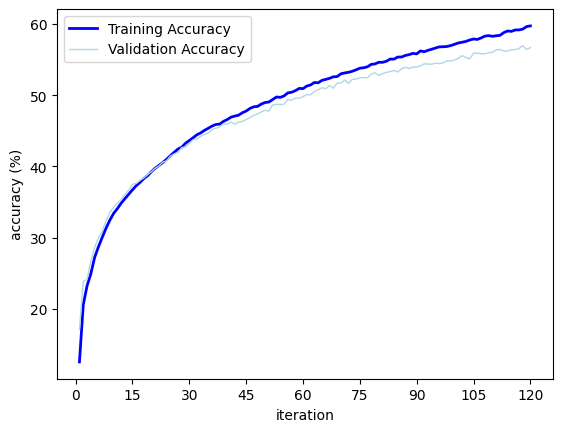

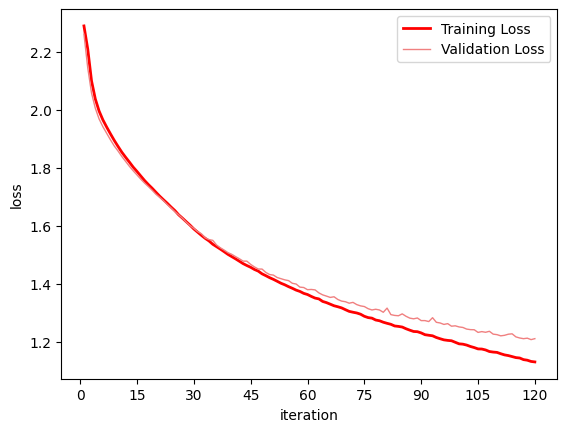

In [29]:
lenet5_trainer.plot(type="accuracy")
lenet5_trainer.plot(type="loss")

### b. Tuned Hyperparameters

In [10]:
# Define LeNet5v2 Class
class LeNet5v2(nn.Module):
    def __init__(self):
        super(LeNet5v2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        x = x.view(-1, 16*5*5) # flatten
        x = self.relu(self.bn3(self.fc1(x)))
        x = self.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)

        return x

In [12]:
# create an instance of LeNet5v2 model
lenet5v2 = LeNet5v2()
lenet5v2 = lenet5v2.to(device)

# define the loss function and optimizer
criterion_lenet5v2 = nn.CrossEntropyLoss()
optimizer_lenet5v2 = optim.Adam(lenet5v2.parameters(), lr=0.001)

# create an instance for lenet 5 trainer
lenet5v2_trainer = Trainer(model=lenet5v2, optimizer=optimizer_lenet5v2, loss_fn=criterion_lenet5v2, dataloaders=cifar10_dataloaders)

In [13]:
lenet5v2_trainer.flop_analysis()
print(lenet5v2_trainer.flop_count)
print(lenet5v2_trainer.parameter_count)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 120])

In [14]:
lenet5v2_trainer.train(60)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/60, Loss: 1.5777, Accuracy: 43.99%, Validation Loss: 1.3418, Validation Accuracy: 51.54%.
Epoch 2/60, Loss: 1.2360, Accuracy: 55.90%, Validation Loss: 1.2598, Validation Accuracy: 54.89%.
Epoch 3/60, Loss: 1.1109, Accuracy: 60.51%, Validation Loss: 1.1749, Validation Accuracy: 58.62%.
Epoch 4/60, Loss: 1.0203, Accuracy: 64.03%, Validation Loss: 1.1370, Validation Accuracy: 59.59%.
Epoch 5/60, Loss: 0.9380, Accuracy: 66.85%, Validation Loss: 1.1320, Validation Accuracy: 60.11%.
Epoch 6/60, Loss: 0.8800, Accuracy: 69.22%, Validation Loss: 1.1262, Validation Accuracy: 60.72%.
Epoch 7/60, Loss: 0.8279, Accuracy: 70.86%, Validation Loss: 1.1155, Validation Accuracy: 61.59%.
Epoch 8/60, Loss: 0.7717, Accuracy: 72.92%, Validation Loss: 1.1618, Validation Accuracy: 61.01%.
Epoch 9/60, Loss: 0.7325, Accuracy: 74.10%, Validation Loss: 1.1510, Validation Accuracy: 61.00%.
Epoch 10/60, Loss: 0.6941, Accuracy: 75.64%, Validation Loss: 1.1881, Validation Accuracy: 60.61%.
Epoch 11/60, Loss: 

In [16]:
accuracy, loss = lenet5v2_trainer.test()
print("test accuracy: ", accuracy,"%")
print("test loss: ", loss)

test accuracy:  58.19 %
test loss:  2.7995159595827515


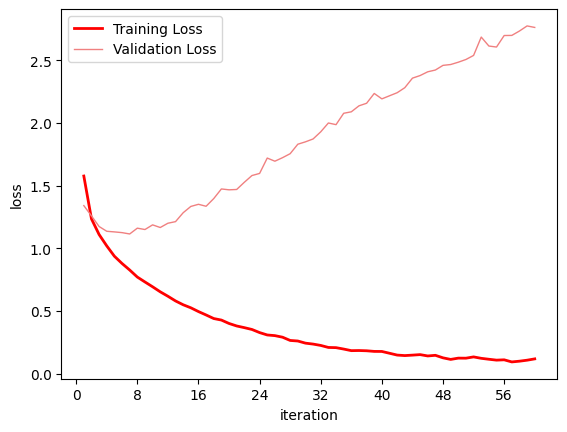

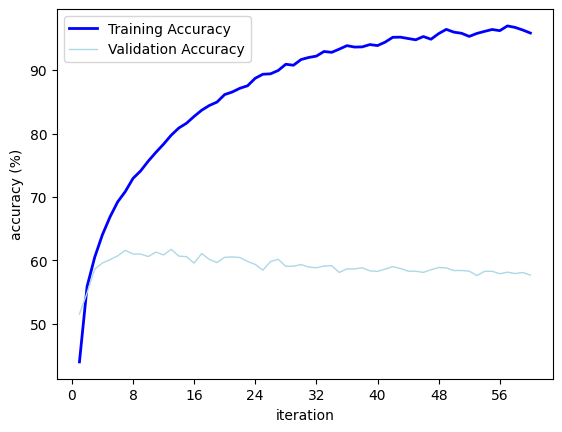

In [15]:
lenet5v2_trainer.plot("loss")
lenet5v2_trainer.plot("accuracy")

# 4. ResNet-18 (from scratch)

In [11]:
# define the basic block, this is the building block of any ResNet
# it consists of 2 convolution layer, with batchnorm applied to the outputs.
# relu is used for activation for both outputs,
# however a skip connection is added to the second layer before passed into relu activation

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        # calling the init method of nn.Module
        super(BasicBlock, self).__init__()
        # first conv layer with any stride
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # second conv layer with fixed stride of 1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # the skip connection if stride is 1 or input=output channels
        self.shortcut = nn.Sequential()

        # if the stride > 1 or the number of input channels differs from output channel,
        # input and output channels will be different either way
        # the skip connection needs to adjust in size
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    # forward pass for the Basic Block
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [12]:
# define the Resnet18 class
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    # this will output the skip connection blocks with the same output channels,
    # for Resnet18, the output channels are 64, 128, 256, 512
    # with each block made up of 2 BasicBlocks
    def _make_layer(self, block, out_channels, n_blocks, stride):
        # lists all the input strides for each BasicBlock
        strides = [stride] + [1]*(n_blocks - 1)
        # empyt container layer for the block
        layers = []
        # loop over the strides. The number of strides is the same as the number of BasicBlocks (in this case 2)
        for stride in strides:
            # append the BasicBlock based on the stride
            layers.append(block(self.in_channels, out_channels, stride))
            # adjust the output channel for the next BasicBlock
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    # forward pass for Resnet18
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        # transform to single vector to be passed into the fully connected layer with linear activation
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [19]:
resnet18 = ResNet18()
resnet18 = resnet18.to(device)
resnet18_criterion = nn.CrossEntropyLoss()
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001)
resnet18_trainer = Trainer(model=resnet18, optimizer=resnet18_optimizer, loss_fn=resnet18_criterion, dataloaders=cifar10_dataloaders, per_batch=False)

In [22]:
resnet18_trainer.train(epoch = 20)

Epoch 1/20, Loss: 0.0536, Accuracy: 99.86%, Validation Loss: 1.3570, Validation Accuracy: 61.58%.
Epoch 2/20, Loss: 0.0447, Accuracy: 99.92%, Validation Loss: 1.3771, Validation Accuracy: 61.17%.
Epoch 3/20, Loss: 0.0373, Accuracy: 99.96%, Validation Loss: 1.4020, Validation Accuracy: 61.20%.
Epoch 4/20, Loss: 0.0326, Accuracy: 99.94%, Validation Loss: 1.4235, Validation Accuracy: 61.48%.
Epoch 5/20, Loss: 0.0283, Accuracy: 99.97%, Validation Loss: 1.4393, Validation Accuracy: 61.51%.
Epoch 6/20, Loss: 0.0247, Accuracy: 99.98%, Validation Loss: 1.4470, Validation Accuracy: 61.22%.
Epoch 7/20, Loss: 0.0217, Accuracy: 99.97%, Validation Loss: 1.4633, Validation Accuracy: 61.43%.
Epoch 8/20, Loss: 0.0188, Accuracy: 99.99%, Validation Loss: 1.4760, Validation Accuracy: 61.65%.
Epoch 9/20, Loss: 0.0182, Accuracy: 99.99%, Validation Loss: 1.4954, Validation Accuracy: 61.33%.
Epoch 10/20, Loss: 0.0165, Accuracy: 99.99%, Validation Loss: 1.5000, Validation Accuracy: 61.59%.
Epoch 11/20, Loss: 

In [27]:
resnet18_trainer.flop_analysis()
print(resnet18_trainer.flop_count)
print(resnet18_trainer.parameter_count)

140594176| name                 | #elements or shape   ||:---------------------|:---------------------|| model                | 11.2M                ||  conv1               |  1.7K                ||   conv1.weight       |   (64, 3, 3, 3)      ||  bn1                 |  0.1K                ||   bn1.weight         |   (64,)              ||   bn1.bias           |   (64,)              ||  layer1              |  0.1M                ||   layer1.0           |   74.0K              ||    layer1.0.conv1    |    36.9K             ||    layer1.0.bn1      |    0.1K              ||    layer1.0.conv2    |    36.9K             ||    layer1.0.bn2      |    0.1K              ||   layer1.1           |   74.0K              ||    layer1.1.conv1    |    36.9K             ||    layer1.1.bn1      |    0.1K              ||    layer1.1.conv2    |    36.9K             ||    layer1.1.bn2      |    0.1K              ||  layer2              |  0.5M                ||   layer2.0           |   0.2M               ||   

In [23]:
accuracy, loss = resnet18_trainer.test()
print("test accuracy: ", accuracy)
print("test loss: ", loss)

test accuracy:  61.31
test loss:  1.5829649997662893


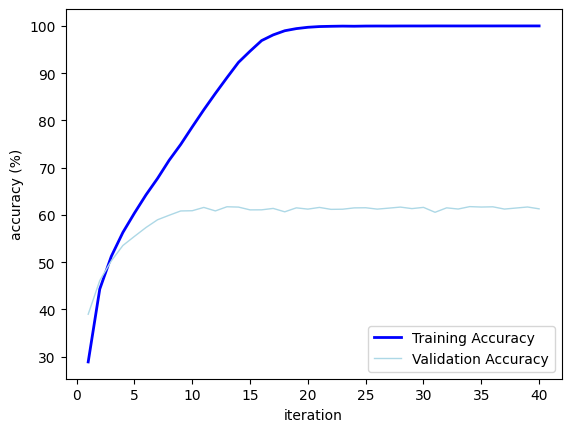

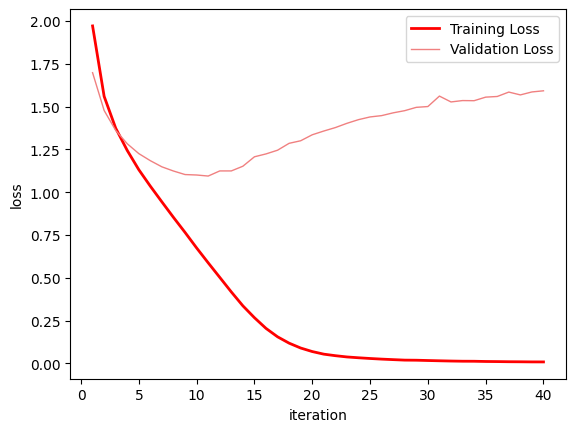

In [24]:
resnet18_trainer.plot("accuracy")
resnet18_trainer.plot("loss")

### b. Tuning

In [15]:
class ResNet18v2(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18v2, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.60)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    # this will output the skip connection blocks with the same output channels,
    # for Resnet18, the output channels are 64, 128, 256, 512
    # with each block made up of 2 BasicBlocks
    def _make_layer(self, block, out_channels, n_blocks, stride):
        # lists all the input strides for each BasicBlock
        strides = [stride] + [1]*(n_blocks - 1)
        # empyt container layer for the block
        layers = []
        # loop over the strides. The number of strides is the same as the number of BasicBlocks (in this case 2)
        for stride in strides:
            # append the BasicBlock based on the stride
            layers.append(block(self.in_channels, out_channels, stride))
            # adjust the output channel for the next BasicBlock
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    # forward pass for Resnet18
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        # transform to single vector to be passed into the fully connected layer with linear activation
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [49]:
resnet18v2 = ResNet18v2()
resnet18v2 = resnet18v2.to(device)
resnet18v2_criterion = nn.CrossEntropyLoss()
resnet18v2_optimizer = optim.Adam(resnet18v2.parameters(), lr=0.001, weight_decay = 0.00001)
resnet18v2_trainer = Trainer(model=resnet18v2, optimizer=resnet18v2_optimizer, loss_fn=resnet18v2_criterion, dataloaders=cifar10_dataloaders_augmented, per_batch=False)

In [56]:
resnet18v2_trainer.train(epoch=20)

Epoch 1/20, Loss: 0.2783, Accuracy: 90.27%, Validation Loss: 0.4321, Validation Accuracy: 88.26%.
Epoch 2/20, Loss: 0.2694, Accuracy: 90.67%, Validation Loss: 0.4791, Validation Accuracy: 87.46%.
Epoch 3/20, Loss: 0.2706, Accuracy: 90.77%, Validation Loss: 0.4909, Validation Accuracy: 86.92%.
Epoch 4/20, Loss: 0.2659, Accuracy: 90.75%, Validation Loss: 0.4681, Validation Accuracy: 87.41%.
Epoch 5/20, Loss: 0.2715, Accuracy: 90.42%, Validation Loss: 0.4445, Validation Accuracy: 88.06%.
Epoch 6/20, Loss: 0.2664, Accuracy: 90.56%, Validation Loss: 0.4527, Validation Accuracy: 88.37%.
Epoch 7/20, Loss: 0.2591, Accuracy: 90.83%, Validation Loss: 0.4542, Validation Accuracy: 88.05%.
Epoch 8/20, Loss: 0.2645, Accuracy: 90.80%, Validation Loss: 0.4680, Validation Accuracy: 87.98%.
Epoch 9/20, Loss: 0.2619, Accuracy: 90.97%, Validation Loss: 0.4652, Validation Accuracy: 87.90%.
Epoch 10/20, Loss: 0.2645, Accuracy: 90.78%, Validation Loss: 0.4337, Validation Accuracy: 88.31%.
Epoch 11/20, Loss: 

In [57]:
accuracy, loss = resnet18v2_trainer.test()
print("test accuracy: ", accuracy,"%")
print("test loss: ", loss)

test accuracy:  87.41 %
test loss:  0.4709907932372033


In [41]:
resnet18v2_trainer.flop_analysis()
print(resnet18v2_trainer.flop_count)
print(resnet18v2_trainer.parameter_count)

140594176| name                 | #elements or shape   ||:---------------------|:---------------------|| model                | 11.2M                ||  conv1               |  1.7K                ||   conv1.weight       |   (64, 3, 3, 3)      ||  bn1                 |  0.1K                ||   bn1.weight         |   (64,)              ||   bn1.bias           |   (64,)              ||  layer1              |  0.1M                ||   layer1.0           |   74.0K              ||    layer1.0.conv1    |    36.9K             ||    layer1.0.bn1      |    0.1K              ||    layer1.0.conv2    |    36.9K             ||    layer1.0.bn2      |    0.1K              ||   layer1.1           |   74.0K              ||    layer1.1.conv1    |    36.9K             ||    layer1.1.bn1      |    0.1K              ||    layer1.1.conv2    |    36.9K             ||    layer1.1.bn2      |    0.1K              ||  layer2              |  0.5M                ||   layer2.0           |   0.2M               ||   

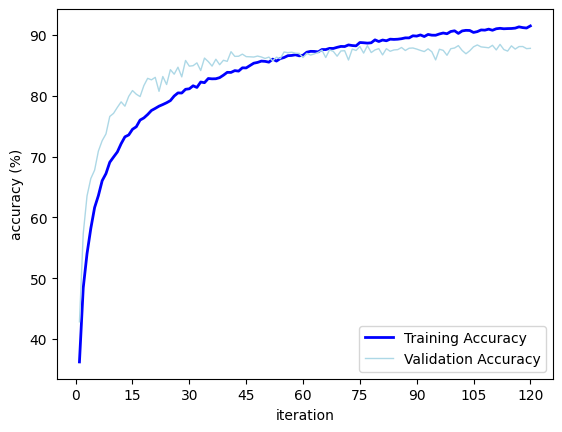

In [58]:
resnet18v2_trainer.plot("accuracy")

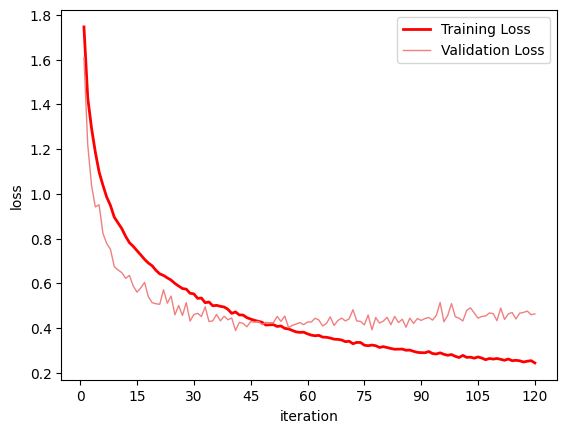

In [59]:
resnet18v2_trainer.plot("loss")

In [17]:
resnet18v3 = ResNet18v2()
resnet18v3 = resnet18v3.to(device)
resnet18v3_criterion = nn.CrossEntropyLoss()
resnet18v3_optimizer = optim.Adam(resnet18v3.parameters(), lr=0.001, weight_decay = 0.00001, amsgrad=True)
resnet18v3_trainer = Trainer(model=resnet18v3, optimizer=resnet18v3_optimizer, loss_fn=resnet18v3_criterion, dataloaders=cifar10_dataloaders_augmented, per_batch=False)

In [23]:
resnet18v3_trainer.train(epoch=20)

Epoch 1/20, Loss: 0.1860, Accuracy: 93.60%, Validation Loss: 0.5321, Validation Accuracy: 87.38%.
Epoch 2/20, Loss: 0.1754, Accuracy: 93.94%, Validation Loss: 0.5484, Validation Accuracy: 87.61%.
Epoch 3/20, Loss: 0.1804, Accuracy: 93.86%, Validation Loss: 0.5242, Validation Accuracy: 87.80%.
Epoch 4/20, Loss: 0.1821, Accuracy: 93.65%, Validation Loss: 0.5372, Validation Accuracy: 87.15%.
Epoch 5/20, Loss: 0.1804, Accuracy: 93.77%, Validation Loss: 0.4807, Validation Accuracy: 88.14%.
Epoch 6/20, Loss: 0.1682, Accuracy: 94.17%, Validation Loss: 0.5069, Validation Accuracy: 87.42%.
Epoch 7/20, Loss: 0.1726, Accuracy: 94.08%, Validation Loss: 0.5207, Validation Accuracy: 87.20%.
Epoch 8/20, Loss: 0.1699, Accuracy: 94.08%, Validation Loss: 0.4948, Validation Accuracy: 87.94%.
Epoch 9/20, Loss: 0.1744, Accuracy: 94.06%, Validation Loss: 0.4869, Validation Accuracy: 87.90%.
Epoch 10/20, Loss: 0.1657, Accuracy: 94.30%, Validation Loss: 0.5213, Validation Accuracy: 87.71%.
Epoch 11/20, Loss: 

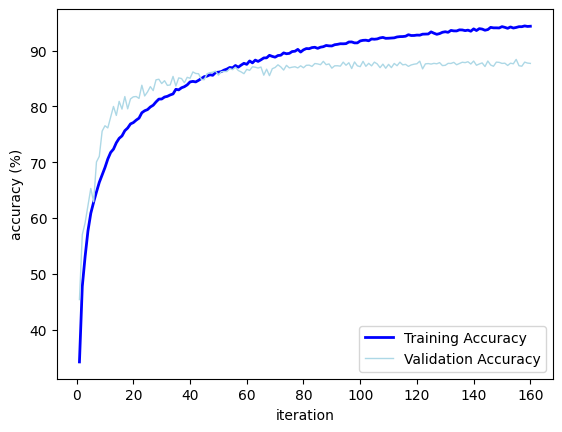

In [24]:
resnet18v3_trainer.plot("accuracy")

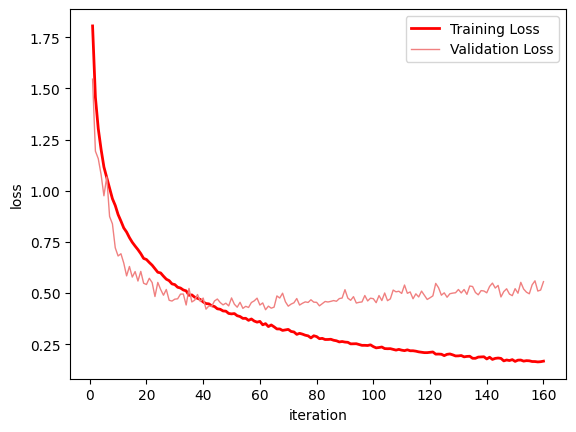

In [25]:
resnet18v3_trainer.plot("loss")

# 5. Plain ResNet-18 (from scratch)

This is a ResNet-18 implementation without skip connections

In [5]:
# define the basic block, this is the building block of Plain ResNet
# it consists of 2 convolution layer, with batchnorm applied to the outputs.
# relu is used for activation for both outputs,
# however no skip connection is added
class BasicBlockPlain(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        # calling the init method of nn.Module
        super(BasicBlockPlain, self).__init__()
        # first conv layer with any stride
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # second conv layer with fixed stride of 1
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    # forward pass for the plain Basic Block
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

In [6]:
# define the Plain Resnet18 class
class PlainResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(PlainResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlockPlain, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlockPlain, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlockPlain, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlockPlain, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    # this will output the skip connection blocks with the same output channels,
    # for Resnet18, the output channels are 64, 128, 256, 512
    # with each block made up of 2 BasicBlocks
    def _make_layer(self, block, out_channels, n_blocks, stride):
        # lists all the input strides for each BasicBlock
        strides = [stride] + [1]*(n_blocks - 1)
        # empyt container layer for the block
        layers = []
        # loop over the strides. The number of strides is the same as the number of BasicBlocks (in this case 2)
        for stride in strides:
            # append the BasicBlock based on the stride
            layers.append(block(self.in_channels, out_channels, stride))
            # adjust the output channel for the next BasicBlock
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    # forward pass for Resnet18
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        # transform to single vector to be passed into the fully connected layer with linear activation
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


In [19]:
plain_resnet18 = PlainResNet18()
plain_resnet18 = plain_resnet18.to(device)
plain_resnet18_criterion = nn.CrossEntropyLoss()
plain_resnet18_optimizer = optim.Adam(plain_resnet18.parameters(), lr=0.001, weight_decay = 0.00001)
plain_resnet18_trainer = Trainer(model=plain_resnet18, optimizer=plain_resnet18_optimizer, loss_fn=plain_resnet18_criterion, dataloaders=cifar10_dataloaders_augmented)

In [20]:
plain_resnet18_trainer.train(epoch=80)

Epoch 1/80, Loss: 1.8880, Accuracy: 26.72%, Validation Loss: 1.7723, Validation Accuracy: 35.35%.
Epoch 2/80, Loss: 1.5790, Accuracy: 41.28%, Validation Loss: 1.4719, Validation Accuracy: 45.56%.
Epoch 3/80, Loss: 1.4427, Accuracy: 47.08%, Validation Loss: 1.2393, Validation Accuracy: 55.18%.
Epoch 4/80, Loss: 1.3349, Accuracy: 51.88%, Validation Loss: 1.2144, Validation Accuracy: 56.34%.
Epoch 5/80, Loss: 1.2645, Accuracy: 54.37%, Validation Loss: 1.3147, Validation Accuracy: 54.36%.
Epoch 6/80, Loss: 1.1974, Accuracy: 57.26%, Validation Loss: 0.9945, Validation Accuracy: 65.49%.
Epoch 7/80, Loss: 1.1394, Accuracy: 59.48%, Validation Loss: 0.9502, Validation Accuracy: 66.13%.
Epoch 8/80, Loss: 1.1035, Accuracy: 60.70%, Validation Loss: 0.9854, Validation Accuracy: 65.15%.
Epoch 9/80, Loss: 1.0561, Accuracy: 62.45%, Validation Loss: 0.8888, Validation Accuracy: 69.32%.
Epoch 10/80, Loss: 1.0285, Accuracy: 63.45%, Validation Loss: 0.9253, Validation Accuracy: 67.97%.
Epoch 11/80, Loss: 

In [21]:
accuracy, loss = plain_resnet18_trainer.test()

print("test accuracy: ", accuracy,"%")
print("test loss: ", loss)

test accuracy:  87.27 %
test loss:  0.38931472392021854


In [53]:
plain_resnet18_trainer.flop_analysis()
print(plain_resnet18_trainer.flop_count)
print(plain_resnet18_trainer.parameter_count)

138992640| name              | #elements or shape   ||:------------------|:---------------------|| model             | 11.0M                ||  conv1            |  1.7K                ||   conv1.weight    |   (64, 3, 3, 3)      ||  bn1              |  0.1K                ||   bn1.weight      |   (64,)              ||   bn1.bias        |   (64,)              ||  layer1           |  0.1M                ||   layer1.0        |   74.0K              ||    layer1.0.conv1 |    36.9K             ||    layer1.0.bn1   |    0.1K              ||    layer1.0.conv2 |    36.9K             ||    layer1.0.bn2   |    0.1K              ||   layer1.1        |   74.0K              ||    layer1.1.conv1 |    36.9K             ||    layer1.1.bn1   |    0.1K              ||    layer1.1.conv2 |    36.9K             ||    layer1.1.bn2   |    0.1K              ||  layer2           |  0.5M                ||   layer2.0        |   0.2M               ||    layer2.0.conv1 |    73.7K             ||    layer2.0.bn1   |  

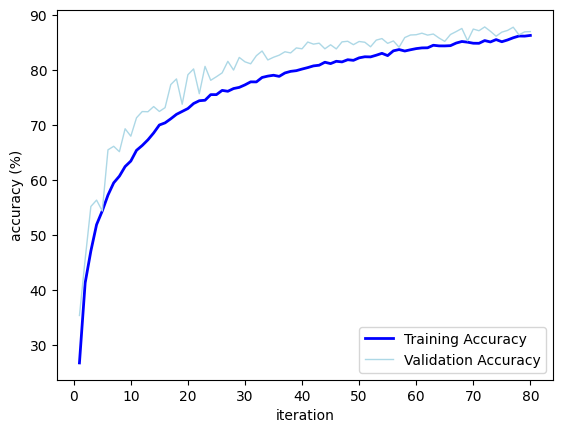

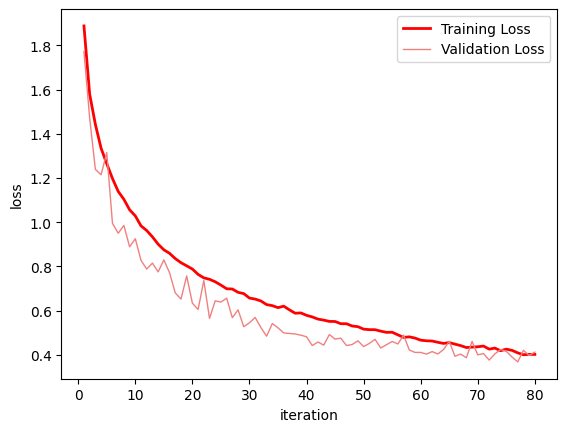

In [22]:
plain_resnet18_trainer.plot("accuracy")
plain_resnet18_trainer.plot("loss")

# 6. AlexNet (fine-tune)

### Fine Tune to Thermal Dogs and People Dataset

In [ ]:
# load the AlexNet model and modify the final layer to match the number of multi-label classes in Thermal Dogs and People Dataset (2)

alexnet = models.alexnet(pretrained=True)

alexnet.classifier[6] = nn.Linear(4096, 2)

alexnet = alexnet.to(device)



# define loss function and optimizer

alixnet_criterion = nn.BCEWithLogitsLoss() # sutiable for multilabel classification

alexnet_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

C:\Users\putra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.  warnings.warn(C:\Users\putra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.  warnings.warn(msg)

In [ ]:
alexnet_trainer = Trainer(alexnet, alexnet_optimizer, alixnet_criterion, thermal_dataloaders, False, 2)

alexnet_trainer.flop_analysis()

print(alexnet_trainer.flop_count)

print(alexnet_trainer.parameter_count)

Unsupported operator aten::max_pool2d encountered 3 time(s)

710109888| name                   | #elements or shape   ||:-----------------------|:---------------------|| model                  | 57.0M                ||  features              |  2.5M                ||   features.0           |   23.3K              ||    features.0.weight   |    (64, 3, 11, 11)   ||    features.0.bias     |    (64,)             ||   features.3           |   0.3M               ||    features.3.weight   |    (192, 64, 5, 5)   ||    features.3.bias     |    (192,)            ||   features.6           |   0.7M               ||    features.6.weight   |    (384, 192, 3, 3)  ||    features.6.bias     |    (384,)            ||   features.8           |   0.9M               ||    features.8.weight   |    (256, 384, 3, 3)  ||    features.8.bias     |    (256,)            ||   features.10          |   0.6M               ||    features.10.weight  |    (256, 256, 3, 3)  ||    features.10.bias    |    (256,)            ||  classifier            |  54.5M               ||   classif

# 7. Mobilenet (fine-tune)

### a. Fine Tune to CIFAR 10

In [ ]:
# load the MobileNet model and modify the final layer to match the number of classes in CIFAR-10 (10)

mobilenetV2 = models.mobilenet_v2(pretrained=True)

mobilenetV2.classifier[1] = nn.Linear(mobilenetV2.classifier[1].in_features, 10)

mobilenetV2 = mobilenetV2.to(device)



# define loss function and optimizer

mobilenetV2_criterion = nn.CrossEntropyLoss()

mobilenetV2_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
mobilenetV2_trainer = Trainer(mobilenetV2, mobilenetV2_optimizer, mobilenetV2_criterion, thermal_dataloaders, False, 2)

mobilenetV2_trainer.flop_analysis()

print(mobilenetV2_trainer.flop_count)

print(mobilenetV2_trainer.parameter_count)

Unsupported operator aten::add_ encountered 52 time(s)Unsupported operator aten::hardtanh_ encountered 35 time(s)Unsupported operator aten::add encountered 10 time(s)

332950112| name                   | #elements or shape   ||:-----------------------|:---------------------|| model                  | 2.2M                 ||  features              |  2.2M                ||   features.0           |   0.9K               ||    features.0.0        |    0.9K              ||    features.0.1        |    64                ||   features.1           |   0.9K               ||    features.1.conv     |    0.9K              ||   features.2           |   5.1K               ||    features.2.conv     |    5.1K              ||   features.3           |   8.8K               ||    features.3.conv     |    8.8K              ||   features.4           |   10.0K              ||    features.4.conv     |    10.0K             ||   features.5           |   14.8K              ||    features.5.conv     |    14.8K             ||   features.6           |   14.8K              ||    features.6.conv     |    14.8K             ||   features.7           |   21.1K              ||    featur

### b. Fine Tune to Thermal Dogs and People Dataset

In [ ]:
# load the MobileNet model and modify the final layer to match the number of multi-label classes in Thermal Dogs and People Dataset (2)

mobilenetV2 = models.mobilenet_v2(pretrained=True)

mobilenetV2.classifier[1] = nn.Linear(mobilenetV2.classifier[1].in_features, 2)

mobilenetV2 = mobilenetV2.to(device)



# define loss function and optimizer

mobilenetV2_criterion = nn.BCEWithLogitsLoss()

mobilenetV2_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
mobilenetV2_trainer = Trainer(mobilenetV2, mobilenetV2_optimizer, mobilenetV2_criterion, thermal_dataloaders, False, 2)

mobilenetV2_trainer.flop_analysis()

print(mobilenetV2_trainer.flop_count)

print(mobilenetV2_trainer.parameter_count)

Unsupported operator aten::add_ encountered 52 time(s)Unsupported operator aten::hardtanh_ encountered 35 time(s)Unsupported operator aten::add encountered 10 time(s)

332950112| name                   | #elements or shape   ||:-----------------------|:---------------------|| model                  | 2.2M                 ||  features              |  2.2M                ||   features.0           |   0.9K               ||    features.0.0        |    0.9K              ||    features.0.1        |    64                ||   features.1           |   0.9K               ||    features.1.conv     |    0.9K              ||   features.2           |   5.1K               ||    features.2.conv     |    5.1K              ||   features.3           |   8.8K               ||    features.3.conv     |    8.8K              ||   features.4           |   10.0K              ||    features.4.conv     |    10.0K             ||   features.5           |   14.8K              ||    features.5.conv     |    14.8K             ||   features.6           |   14.8K              ||    features.6.conv     |    14.8K             ||   features.7           |   21.1K              ||    featur

# 8. ViT (fine-tune)

### a. Fine Tune to CIFAR-10 Dataset

It's Already trained on CIFAR-10

In [ ]:
# load the ViT model and modify the final layer to match the number of classes in CIFAR-10 (10)

vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

vit.classifier = nn.Linear(vit.classifier.in_features, 2) # Modify the final layer for 2 labels (dog and person)

vit = vit.to(device)



# define loss function and optimizer

vit_criterion = nn.CrossEntropyLoss()

vit_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
vit_trainer = Trainer(vit, vit_optimizer, vit_criterion, thermal_dataloaders_vit, False, 2)

# vit_trainer.train()

vit_trainer.flop_analysis()

print(vit_trainer.flop_count)

print(vit_trainer.parameter_count)

torch.Size([3, 224, 224])

Unsupported operator aten::add encountered 25 time(s)Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)Unsupported operator aten::gelu encountered 12 time(s)The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.vit.encoder.layer.0.attention.attention.dropout, vit.encoder.layer.1.attention.attention.dropout, vit.encoder.layer.10.attention.attention.dropout, vit.encoder.layer.11.attention.attention.dropout, vit.encoder.layer.2.attention.attention.dropout, vit.encoder.layer.3.attention.attention.dropout, vit.encoder.layer.4.attention.attention.dropout, vit.encoder.layer.5.attention.attention.dropout, vit.encoder.layer.6.attention.attention.dropout, vit.encoder.layer.7.attention.attention.dropout, vi

16866646272| name                                  | #elements or shape   ||:--------------------------------------|:---------------------|| model                                 | 85.8M                ||  vit                                  |  85.8M               ||   vit.embeddings                      |   0.7M               ||    vit.embeddings.cls_token           |    (1, 1, 768)       ||    vit.embeddings.position_embeddings |    (1, 197, 768)     ||    vit.embeddings.patch_embeddings    |    0.6M              ||   vit.encoder                         |   85.1M              ||    vit.encoder.layer                  |    85.1M             ||   vit.layernorm                       |   1.5K               ||    vit.layernorm.weight               |    (768,)            ||    vit.layernorm.bias                 |    (768,)            ||  classifier                           |  1.5K                ||   classifier.weight                   |   (2, 768)           ||   classifier.bias          

### b. Fine Tune to Thermal Dogs and People Dataset

In [ ]:
# load the ViT model and modify the final layer to match the number of multi-label classes in Thermal Dogs and People Dataset (2)

vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

vit.classifier = nn.Linear(vit.classifier.in_features, 2) # Modify the final layer for 2 labels (dog and person)

vit = vit.to(device)



# define loss function and optimizer

vit_criterion = nn.BCEWithLogitsLoss()

vit_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

In [ ]:
vit_trainer = Trainer(vit, vit_optimizer, vit_criterion, thermal_dataloaders_vit, False, 2)

vit_trainer.flop_analysis()

print(vit_trainer.flop_count)

print(vit_trainer.parameter_count)

Unsupported operator aten::add encountered 25 time(s)Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)Unsupported operator aten::gelu encountered 12 time(s)The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.vit.encoder.layer.0.attention.attention.dropout, vit.encoder.layer.1.attention.attention.dropout, vit.encoder.layer.10.attention.attention.dropout, vit.encoder.layer.11.attention.attention.dropout, vit.encoder.layer.2.attention.attention.dropout, vit.encoder.layer.3.attention.attention.dropout, vit.encoder.layer.4.attention.attention.dropout, vit.encoder.layer.5.attention.attention.dropout, vit.encoder.layer.6.attention.attention.dropout, vit.encoder.layer.7.attention.attention.dropout, vi

16866646272| name                                  | #elements or shape   ||:--------------------------------------|:---------------------|| model                                 | 85.8M                ||  vit                                  |  85.8M               ||   vit.embeddings                      |   0.7M               ||    vit.embeddings.cls_token           |    (1, 1, 768)       ||    vit.embeddings.position_embeddings |    (1, 197, 768)     ||    vit.embeddings.patch_embeddings    |    0.6M              ||   vit.encoder                         |   85.1M              ||    vit.encoder.layer                  |    85.1M             ||   vit.layernorm                       |   1.5K               ||    vit.layernorm.weight               |    (768,)            ||    vit.layernorm.bias                 |    (768,)            ||  classifier                           |  1.5K                ||   classifier.weight                   |   (2, 768)           ||   classifier.bias          